In [1]:
# Это просто чтобы на проекторе всё было красиво.
# Не обращайте внимания

from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.8em;
line-height:1.0em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.4em;
line-height:1.3em;
padding-left:2em;
padding-right:2em;
}
</style>
""")

# Классификация

## K ближайших соседей kNN

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

kNN - это метрический алгоритм, предполагающий, что объекты одного класса в пространстве находятся близко друг к другу. В зависимости от выбора k - количества ближайших соседей и метрики расстояния, качество может сильно отличаться. Страдает от проклятия размерностей. Ленивый, значит проивзодит все вычисления при предсказании, а не при обучении. Хранит всю тренировочную выборку в себе.

Идея алгоритма:
1. Взять новый объект и вычислить все расстояния по некоторой метрике от него до других объектов
2. Выбрать k ближайших соседей к этому объекту
3. Класс объекта - это класс наиболее часто встречающегося объекта среди k соседей.

В алгоритм можно внести изменение добавив веса для каждого объекта или класса. Например, при выборе класса смотрят не на большинство соседей, а на какую-то взвешенную сумму.

Кстати алгоритм можо свести к регрессии, если брать среднее значение целевой переменной по k соседям.

Можно решать задачи классификации, регрессии, рекомендации.

### Литература

- [Ближайшие соседи - sklearn](http://scikit-learn.org/stable/modules/neighbors.html)
- [ODS классификация](https://habrahabr.ru/company/ods/blog/322534/#metod-blizhayshih-sosedey)
- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)

### sklearn.neighbors.KNeighborsClassifier

[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

Основные параметры класса sklearn.neighbors.KNeighborsClassifier:

- weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
- algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем — расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
- leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
- metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

_взято из курса [ODS](https://habrahabr.ru/company/ods/blog/322534/#metod-blizhayshih-sosedey)_

### Метрики расстояния

Аксиомы метрики:

1. $\rho(x,y) \ge 0$
2. $\rho(x,y) = \rho(y,x)$
3. $\rho(x,y) \ge \rho(x,z) + \rho(z,y)$

#### Евклидова метрика

$\large \rho(x,y) = \sqrt{\sum_{i=1}^{n}{(x_i - y_i)^2}}$

#### Манхэттенская метрика

$\large \rho(x,y) = \sum_{i=1}^{n}{|x_i - y_i|}$

####  Минковского метрика

$\large \rho(x,y) = {(\sum_{i=1}^{n}{|x_i - y_i| ^ q})} ^ \frac{1}{q}$

![](https://i.imgur.com/0aBH1bO.png)

### Проклятье размерности

![](https://i.imgur.com/VZkE79X.png)

$\LARGE \lim_{n \rightarrow \infty}{0.99^n} = 0$

## Практика

### Классификация

Рассмотрим наш любимый датасет с цифрами MNIST. Мы его уже решали весьма успешно с помощью одного метрического алгоритма кластеризации, поэтому возможно тут тоже будет всё хорошо.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# Зафиксируем случайность, чтобы каждый раз получалось одно и тоже
np.random.seed(seed=42)

In [3]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True)

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


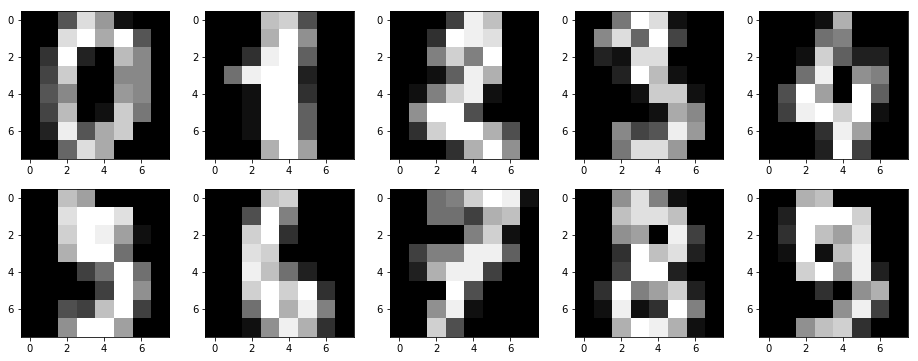

In [4]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray')

In [5]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

Как мы с вами помним, классификацию по очень несбалансированным выборкам делать сложно и нужно брать специальные метрики и хитрые разбиения на трейн-тест. Посмотрим, как у нас дела обстоят с цирфами.

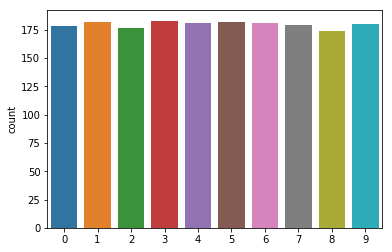

In [6]:
sns.countplot(y)

Целевой признак распределен равномерно по всем классам с некоторой погрешность. Поэтому можно считать в лоб обычную точность предсказания и не бояться, что интерпретация будет неадекватна. НО при кроссвалидации происходят случайные подвыборки объектов, нам нужно очобым образом стратифицировать разбиение, чтобы сохранялись пропорции классов. Для этих целей используют StratifiedKFold.

In [7]:
clf = KNeighborsClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv)

print("Accuracy: {}".format(scores.mean()))

Accuracy: 0.9838396055603897


Отлично, хорошая точность, но где у нас сосредоточены ошибки? В чём проблема предсказания? Хотелось бы получить красивый отчет, вдруг мы просто неправильно предсказываем часть 1 и 7??

Воспользуемся функцией [classification-report](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-report), которая выведет precision, recall, f1-score, support и confusion_matrix, по которой мы поймем что с чем путает алгоритм.

![](https://i.imgur.com/8xhLDz8.png)

$\LARGE precision = \frac{TP}{TP+FP}$

$\LARGE recall = \frac{TP}{TP+FN}$

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       100
          1       0.95      1.00      0.98       104
          2       1.00      0.99      0.99        96
          3       0.97      0.94      0.95       113
          4       0.98      0.99      0.99       112
          5       0.98      0.97      0.97       118
          6       1.00      0.99      1.00       119
          7       0.92      1.00      0.96       108
          8       0.95      0.93      0.94        98
          9       0.95      0.90      0.93       111

avg / total       0.97      0.97      0.97      1079



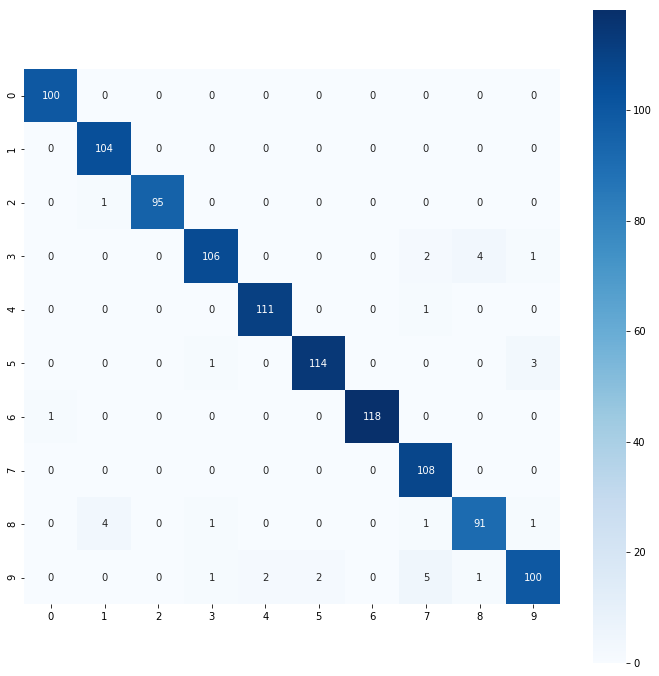

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.6)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

### Тюнинг гиперпараметров

Как улучшить качество предсказания?

Самый просто способ для того чтобы подобрать лучший параметр - это перебрать их ВСЕ с помощью [GridSearch](http://scikit-learn.org/stable/modules/grid_search.html)

![](https://pp.userapi.com/c639616/v639616016/4938d/-9s9ffsvAC0.jpg)

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
np.arange(1, 10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
params = {
    "n_neighbors": np.arange(1, 10), 
    "p": [2,4]
}

search = GridSearchCV(KNeighborsClassifier(), params, n_jobs=2, 
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2)
%time search.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] n_neighbors=1, p=2 ..............................................
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=2, total=   0.1s
[CV] ............................... n_neighbors=1, p=2, total=   0.1s
[CV] n_neighbors=1, p=2 ..............................................
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=2, total=   0.1s
[CV] n_neighbors=1, p=2 ..............................................
[CV] ............................... n_neighbors=1, p=2, total=   0.1s
[CV] n_neighbors=1, p=4 ..............................................
[CV] ............................... n_neighbors=1, p=2, total=   0.1s
[CV] n_neighbors=1, p=4 ..............................................
[CV] ............................... n_neighbors=1, p=4, total=   1.4s
[CV] n_neighbors

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   41.2s


[CV] ............................... n_neighbors=4, p=4, total=   1.2s
[CV] n_neighbors=4, p=4 ..............................................
[CV] ............................... n_neighbors=4, p=4, total=   1.2s
[CV] n_neighbors=5, p=2 ..............................................
[CV] ............................... n_neighbors=5, p=2, total=   0.1s
[CV] n_neighbors=5, p=2 ..............................................
[CV] ............................... n_neighbors=5, p=2, total=   0.1s
[CV] n_neighbors=5, p=2 ..............................................
[CV] ............................... n_neighbors=5, p=2, total=   0.1s
[CV] n_neighbors=5, p=2 ..............................................
[CV] ............................... n_neighbors=5, p=2, total=   0.1s
[CV] n_neighbors=5, p=2 ..............................................
[CV] ............................... n_neighbors=5, p=2, total=   0.1s
[CV] n_neighbors=5, p=4 ..............................................
[CV] .

[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:  2.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'p': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

BEST: score=0.989983305509182, params={'n_neighbors': 1, 'p': 4}


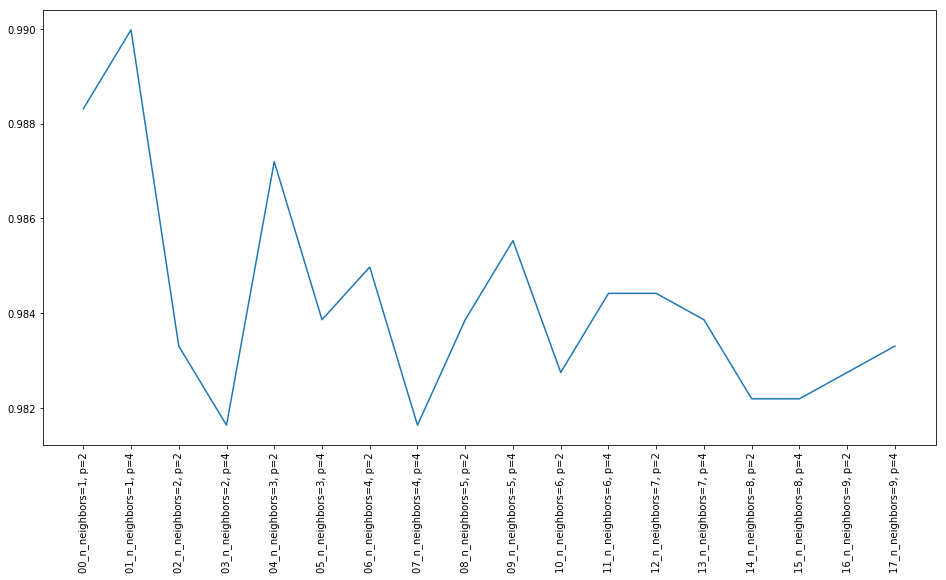

In [12]:
x_ticks = ["{:02d}_n_neighbors={}, p={}".format(i, p['n_neighbors'], p['p']) for i,p in enumerate(search.cv_results_['params'])]

plt.figure(figsize=(16,8))
plt.plot(x_ticks, search.cv_results_['mean_test_score'])
_ =plt.xticks(rotation=90)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       100
          1       0.93      1.00      0.96       104
          2       0.98      1.00      0.99        96
          3       0.96      0.97      0.97       113
          4       0.99      0.96      0.98       112
          5       0.97      0.98      0.98       118
          6       1.00      0.99      1.00       119
          7       0.92      1.00      0.96       108
          8       0.98      0.92      0.95        98
          9       0.99      0.88      0.93       111

avg / total       0.97      0.97      0.97      1079



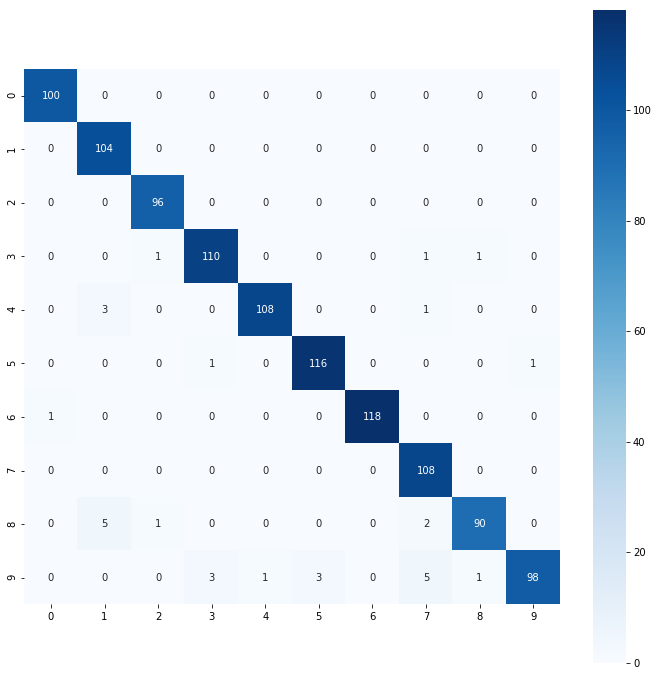

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, p=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

### Рекомендательная система

А эту задачу вы решите дома.

![](https://i.imgur.com/hn3xjZl.png)

_картинка из курса МФТИ_

### Классификация текстов

На примере [датасета SMS спама](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) научим наш классификатор отличать спам от обычного сообщения. Посмотрим как Наивный байесовский метод решает эту задачу и kNN. 

In [14]:
data = pd.read_csv('../../data/SMSSpamCollection.tsv.gz', compression='gzip', sep='\t', header=None, names=['target', 'text'])
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
# Посмотрим на типичны представителей датасета
print(data['target'][2], data['text'][2])
print()
print(data['target'][13], data['text'][13])

spam Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.


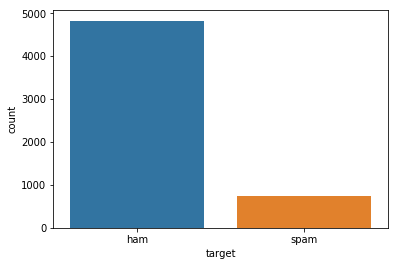

In [16]:
sns.countplot(data['target'])

In [17]:
data['len'] = data['text'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10cbe9eb8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x112488908>], dtype=object)

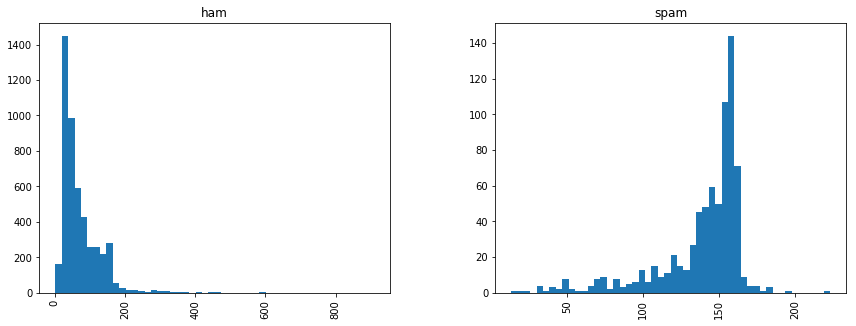

In [18]:
data.hist(column='len', by='target', bins=50,figsize=(14,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x112a349b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x113144198>], dtype=object)

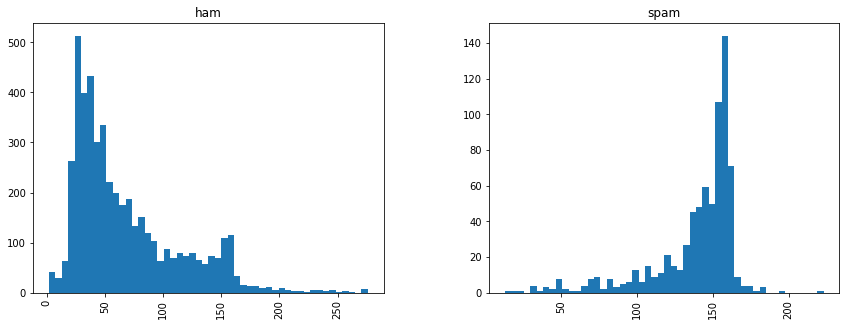

In [19]:
# какие-то странные длинные смс-ки. Посмотрим на распределение по-другому.
data[data['len'] < 280].hist(column='len', by='target', bins=50,figsize=(14,5))

### Генерация признаков текста 


![](https://cs5.pikabu.ru/images/previews_comm/2015-10_5/144549937818821131.jpg)


[Sklearn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

#### Count Vectorizer

Можно начать с очень простой идеи. Давайте разобъем данные на слова. Составим словарь всех слов, которые будут встречаться в наших выборках. И отметим, встречается ли это слово в нашем примере. Получается что каждому объекту выборки будет сопоставлен вектор.



In [20]:
y = data['target']
X = data['text']

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
X_vector = vectorizer.fit_transform(X)

In [22]:
# vectorizer.get_stop_words()

In [23]:
print(len(vectorizer.vocabulary_))
X_vector.shape

3965


(5572, 3965)

In [24]:
sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=True)[:50]

[('zoe', 3964),
 ('zed', 3963),
 ('yup', 3962),
 ('yuo', 3961),
 ('yunny', 3960),
 ('yun', 3959),
 ('yummy', 3958),
 ('yrs', 3957),
 ('yr', 3956),
 ('youre', 3955),
 ('yor', 3954),
 ('yogasana', 3953),
 ('yoga', 3952),
 ('yo', 3951),
 ('ym', 3950),
 ('yijue', 3949),
 ('yetunde', 3948),
 ('yesterday', 3947),
 ('yest', 3946),
 ('yes', 3945),
 ('yer', 3944),
 ('yep', 3943),
 ('yellow', 3942),
 ('yelling', 3941),
 ('yeh', 3940),
 ('years', 3939),
 ('year', 3938),
 ('yeah', 3937),
 ('yck', 3936),
 ('yay', 3935),
 ('yarasu', 3934),
 ('yar', 3933),
 ('yan', 3932),
 ('yahoo', 3931),
 ('ya', 3930),
 ('xy', 3929),
 ('xxxxx', 3928),
 ('xxxx', 3927),
 ('xxx', 3926),
 ('xx', 3925),
 ('xuhui', 3924),
 ('xmas', 3923),
 ('xin', 3922),
 ('xchat', 3921),
 ('xavier', 3920),
 ('xam', 3919),
 ('x49', 3918),
 ('wylie', 3917),
 ('www', 3916),
 ('wun', 3915)]

In [25]:
from sklearn.dummy import DummyClassifier

dm = DummyClassifier()
%time cross_val_score(dm, X_vector, y, cv=3).mean()

CPU times: user 36.5 ms, sys: 694 µs, total: 37.2 ms
Wall time: 37.6 ms


0.77153736509167592

In [26]:
%time cross_val_score(KNeighborsClassifier(n_neighbors=42, n_jobs=4), X_vector, y, cv=3).mean()

CPU times: user 878 ms, sys: 1e+03 ms, total: 1.88 s
Wall time: 2.55 s


0.86593681835756031

А что скажет Байес?

![](https://i.pinimg.com/736x/22/7e/52/227e52ea4622a62344f1bc0a31111f43--bayes-theorem-game-theory.jpg)

$\LARGE P(A|B) = \frac{P(AB)}{P(B)} =  \frac{P(B \mid A)\, P(A)}{P(B)}$

In [27]:
from sklearn.naive_bayes import MultinomialNB

In [28]:
%time cross_val_score(MultinomialNB(alpha=1), X_vector, y, cv=3).mean()

CPU times: user 78.7 ms, sys: 3.93 ms, total: 82.7 ms
Wall time: 84.7 ms


0.9824122845915696

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_vector, y, random_state=42, test_size=0.5)

In [30]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

        ham       0.94      1.00      0.97      2416
       spam       1.00      0.61      0.76       370

avg / total       0.95      0.95      0.94      2786

[[2416    0]
 [ 143  227]]


In [31]:
clf = MultinomialNB(alpha=4)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

        ham       0.99      1.00      0.99      2416
       spam       0.98      0.92      0.95       370

avg / total       0.99      0.99      0.99      2786

[[2408    8]
 [  30  340]]


### Классификация текстов

http://scikit-learn.org/stable/datasets/twenty_newsgroups.html

In [32]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']